In [1]:
import numpy as np
import pandas as pd
import math
from math import pi
from datetime import time, datetime
from os import path
from scipy import stats
from statsmodels.stats.power import TTestIndPower
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline
sns.set()
red = (255/255,103/255,103/255)
blue = (52/255,128/255,255/255)

# Performance Outcomes in NFL Quarterbacks Following Shoulder Surgery

### Load Data

First we load our list of QBs, that we have downloaded and selected in the other notebook:

In [3]:
case_qbs = pd.read_csv('qb-data/case_qbs.csv')
ctrl_qbs = pd.read_csv('qb-data/ctrl_qbs.csv')
inj_qbs = pd.read_csv('qb-data/injured_qbs.csv')
select_ctrls = {'Alex Smith': 'Michael Vick',
 'Andrew Luck': 'Joe Flacco',
 'Cam Newton': 'Robert Griffin III',
 'Chad Pennington': 'Tony Romo',
 'Don Majkowski': 'Erik Kramer',
 'Drew Brees': 'Peyton Manning',
 'Jay Cutler': 'Matt Schaub',
 'Jim McMahon': 'Jim Everett',
 'Jimmy Clausen': 'Kellen Clemens',
                'Kelly Holcomb': 'Donald Hollas',
#  'Kelly Holcomb': 'Jim Miller',
 'Mark Sanchez': 'Kyle Orton',
 'Matt Moore': 'Geno Smith',
 'Matthew Stafford': 'Drew Bledsoe',
 'Rich Gannon': 'Tommy Kramer',
 'Ryan Leaf': 'Tim Couch',
 'Steve McNair': 'Donovan McNabb',
 'Tom Brady': 'Brett Favre',
 'Troy Aikman': 'John Elway',
 'Gary Danielson': 'Jim Kelly'}

Methods to access our CSV files of performance statistics:

In [4]:
def underscore(name):
    sep = name.find(' ')
    return name[:sep]+'_'+name[sep+1:]

def get_qb_stats(name, attempts=1, average=False):
    filesuff = '{}.csv'.format(underscore(name))
    if path.exists('qb-data/case/'+filesuff):
        df = pd.read_csv('qb-data/case/'+filesuff)
    elif path.exists('qb-data/control/'+filesuff):
        df = pd.read_csv('qb-data/control/'+filesuff)
    else:
        return 
    df = df[df['Att']>attempts]
    df.reset_index(drop=True, inplace=True)
    if average:
        return df.mean()
    return df

In [5]:
get_qb_stats('Tom Brady', average=False).tail()

,Year,Date,Age,Cmp,Att,Cmp%,Yds,TD,Int,Rate,Sk,Yds.1,Y/A,AY/A
295,2020,2020-11-23,43.112,26.0,48.0,54.17,216.0,2.0,2.0,62.5,1.0,7.0,4.50,3.46
296,2020,2020-11-29,43.118,27.0,41.0,65.85,345.0,3.0,2.0,96.1,1.0,3.0,8.41,7.68
297,2020,2020-12-13,43.132,15.0,23.0,65.22,196.0,2.0,0.0,120.9,0.0,0.0,8.52,10.26
298,2020,2020-12-20,43.139,31.0,45.0,68.89,390.0,2.0,0.0,110.4,3.0,25.0,8.67,9.56
299,2020,2020-12-26,43.145,22.0,27.0,81.48,348.0,4.0,0.0,158.3,1.0,7.0,12.89,15.85


Methods to select QB games by date, selecting all games or # of games before or after the date:

In [6]:
def format_date(date):
    month_i = date.find('/', 3)
    day_i = date.find('/')
    month = date[:day_i]
    day = date[day_i+1:month_i]
    if len(day)==1:
        day = '0'+day
    if len(month)==1:
        month = '0'+month
    newdate = date[-4:]+'-'+month+'-'+day
    return newdate

def get_qb_games(name, date, all_games=False, games=0, average=False, before=False, after=False):
    df = get_qb_stats(name)
    if df is None:
        return
    if '/' in date:
        date = format_date(date)
    i = 0
    for d in df['Date']:
        if d>=date:
            break
        else:
            i+=1 
    if all_games:
        if before and not after:
            df = df.iloc[0:i,:].reset_index(drop=True)
        elif after and not before:
            df = df.iloc[i:,:].reset_index(drop=True)
    else:
        if before:
            before_i = 0 if i-games<0 else i-games
            df = df.iloc[before_i:i,:].reset_index(drop=True)
        elif after:
            df = df.iloc[i:i+games,:].reset_index(drop=True)
        else: 
            df = df.iloc[i-games:i+games,:].reset_index(drop=True)   
    if average:
        newdf = pd.DataFrame(data={'Games': len(df), 'Age': [df['Age'].mean()], 'Cmp': [df['Cmp'].mean()], 'Att': [df['Att'].mean()], 'Cmp%': [df['Cmp%'].mean()], 'Yds': [df['Yds'].mean()], 'TD': [df['TD'].mean()], 'Int': [df['Int'].mean()], 'Rate': [df['Rate'].mean()], 'Sk': [df['Sk'].mean()], 'Yds.1': [df['Yds.1'].mean()], 'Y/A': [df['Y/A'].mean()], 'AY/A': [df['AY/A'].mean()]})
        return newdf
    else:
        return df 

In [7]:
get_qb_games('Tom Brady', '12/30/2015', games=10, before=True)

,Year,Date,Age,Cmp,Att,Cmp%,Yds,TD,Int,Rate,Sk,Yds.1,Y/A,AY/A
0,2015,2015-10-25,38.083,34.0,54.0,62.96,355.0,2.0,0.0,94.3,3.0,18.0,6.57,7.31
1,2015,2015-10-29,38.087,26.0,38.0,68.42,356.0,4.0,0.0,133.2,2.0,14.0,9.37,11.47
2,2015,2015-11-08,38.097,26.0,39.0,66.67,299.0,2.0,1.0,96.0,0.0,0.0,7.67,7.54
3,2015,2015-11-15,38.104,26.0,42.0,61.90,334.0,2.0,1.0,92.8,3.0,5.0,7.95,7.83
4,2015,2015-11-23,38.112,20.0,39.0,51.28,277.0,1.0,1.0,72.3,1.0,6.0,7.10,6.46
5,2015,2015-11-29,38.118,23.0,42.0,54.76,280.0,3.0,0.0,99.3,3.0,18.0,6.67,8.10
6,2015,2015-12-06,38.125,29.0,56.0,51.79,312.0,3.0,2.0,71.4,4.0,24.0,5.57,5.04
7,2015,2015-12-13,38.132,22.0,30.0,73.33,226.0,2.0,0.0,116.8,3.0,29.0,7.53,8.87
8,2015,2015-12-20,38.139,23.0,35.0,65.71,267.0,2.0,0.0,107.7,2.0,14.0,7.63,8.77
9,2015,2015-12-27,38.146,22.0,31.0,70.97,231.0,1.0,1.0,89.6,2.0,10.0,7.45,6.65


Method to get QB stats before or after a specified QB age:

In [28]:
def get_qb_stats_by_age(name, age, all_games=True, n_games=0, before=False, after=False):
    stats = get_qb_stats(name)
    if stats is None:
        return
    for a in stats['Age']:
        if a>age:
            qb_age = a
            break
    if age>a:
        return
    qb_date = stats[stats['Age']==qb_age]['Date'].to_string(index=False)[:] 
    if all_games:
        if after:
            result = get_qb_games(name, qb_date, all_games=True, average=True, after=True)
        else:
            result = get_qb_games(name, qb_date, all_games=True, average=True, before=True)
    else:
        if after:
            result = get_qb_games(name, qb_date, games=n_games, average=False, after=True)
        else:
            result = get_qb_games(name, qb_date, games=n_games, average=True, before=True)
    return result

In [29]:
get_qb_stats_by_age('Tom Brady', 27.5, all_games=True, before=True)

,Games,Age,Cmp,Att,Cmp%,Yds,TD,Int,Rate,Sk,Yds.1,Y/A,AY/A
0,64,25.580125,19.421875,31.53125,60.684063,217.578125,1.515625,0.8125,86.8625,2.03125,12.296875,6.84875,6.680781


Now we can get our case qbs and their controls average stats before and after their surgery age, or respective index age:

In [30]:
def compile_before_after(caseslist, controlslist):
    compare_qbs = pd.DataFrame()
    for i, row in caseslist.iterrows():
        case_prev = get_qb_stats_by_age(row.Name, row.SurgeryAge, before=True)
        case_post = get_qb_stats_by_age(row.Name, row.SurgeryAge, after=True)
        ctrl_prev = get_qb_stats_by_age(controlslist[row.Name], row.SurgeryAge, before=True)
        ctrl_post = get_qb_stats_by_age(controlslist[row.Name], row.SurgeryAge, after=True)
        case = case_prev.append(case_post)
        case['Name'] = row.Name
        ctrl = ctrl_prev.append(ctrl_post)
        ctrl['Name'] = select_ctrls[row.Name]
        compare_qbs = compare_qbs.append(case)
        compare_qbs = compare_qbs.append(ctrl)
    compare_qbs.reset_index(drop=True, inplace=True)
    cols = list(compare_qbs.columns)
    cols = cols[-1:] + cols[:-1]
    compare_qbs = compare_qbs[cols]
    return compare_qbs

In [31]:
cases_and_controls = compile_before_after(case_qbs, select_ctrls)
cases_and_controls.head()

,Name,Games,Age,Cmp,Att,Cmp%,Yds,TD,Int,Rate,Sk,Yds.1,Y/A,AY/A
0,Alex Smith,30,22.115333,14.500000,26.600000,55.359667,155.966667,0.633333,1.033333,65.130000,2.666667,16.600000,5.914000,4.574667
1,Alex Smith,140,30.130007,19.942857,31.142857,64.533857,220.021429,1.271429,0.542857,92.314286,2.485714,13.842857,7.185571,7.294429
2,Michael Vick,43,22.765023,11.906977,22.209302,53.791163,153.930233,0.837209,0.604651,78.306977,2.534884,15.093023,6.885116,6.555116
3,Michael Vick,85,29.514729,15.211765,26.552941,57.080353,186.352941,1.141176,0.729412,82.440000,2.423529,14.435294,7.050353,6.871059
4,Andrew Luck,70,24.857086,22.428571,37.871429,59.812429,272.542857,1.885714,0.971429,88.327143,2.228571,14.142857,7.285571,7.185143


Lets split them up into individual DataFrames for now:

In [32]:
def get_case_control_prev_post(caseslist, controlslist):
    compare = compile_before_after(caseslist, controlslist)
    droplist = []
    for i in range(len(compare)):
        if i not in range(3,len(compare),4):
            droplist.append(i)
    ctrl_post = compare.drop(index=droplist)
    droplist = []
    for i in range(len(compare)):
        if i not in range(2,len(compare),4):
            droplist.append(i)
    ctrl_prev = compare.drop(index=droplist)
    droplist = []
    for i in range(len(compare)):
        if i not in range(1,len(compare),4):
            droplist.append(i)
    case_post = compare.drop(index=droplist)
    droplist = []
    for i in range(len(compare)):
        if i not in range(0,len(compare),4):
            droplist.append(i)
    case_prev = compare.drop(index=droplist)
    ctrl_post.reset_index(drop=True, inplace=True)
    ctrl_prev.reset_index(drop=True, inplace=True)
    case_post.reset_index(drop=True, inplace=True)
    case_prev.reset_index(drop=True, inplace=True)
    return case_prev, case_post, ctrl_prev, ctrl_post

In [33]:
case_prev, case_post, ctrl_prev, ctrl_post = get_case_control_prev_post(case_qbs, select_ctrls)
case_prev.head()

,Name,Games,Age,Cmp,Att,Cmp%,Yds,TD,Int,Rate,Sk,Yds.1,Y/A,AY/A
0,Alex Smith,30,22.115333,14.500000,26.600000,55.359667,155.966667,0.633333,1.033333,65.130000,2.666667,16.600000,5.914000,4.574667
1,Andrew Luck,70,24.857086,22.428571,37.871429,59.812429,272.542857,1.885714,0.971429,88.327143,2.228571,14.142857,7.285571,7.185143
2,Cam Newton,93,24.641366,18.387097,31.483871,58.929032,234.107527,1.462366,0.838710,88.080645,2.376344,18.290323,7.569247,7.420538
3,Chad Pennington,41,26.918659,17.512195,26.609756,63.908537,197.341463,1.292683,0.658537,93.358537,1.634146,10.000000,7.691707,7.488293
4,Don Majkowski,44,24.859818,16.704545,30.113636,53.530909,208.659091,1.159091,1.045455,73.731818,2.727273,15.886364,6.847955,5.980909


### Verify Normal Distribution

Lets take the whole population of NFL QBs - 269 in total, and look at the distribution of statistics:

In [34]:
def get_all_qb_career_stats(caseslist, controlslist):
    all_qbs = get_qb_stats('Alex Smith', average=True)
    all_qbs = all_qbs.to_frame().T
    for i, row in caseslist.iterrows():
        qb_stats = get_qb_stats(row.Name, average=True)
        if i != 0:
            all_qbs = all_qbs.append(qb_stats, ignore_index=True)
    for i, row in controlslist.iterrows():
        qb_stats = get_qb_stats(row.Name, average=True)
        if stats is not None:
            all_qbs = all_qbs.append(qb_stats, ignore_index=True)
    return all_qbs

In [35]:
all_qb_stats = get_all_qb_career_stats(case_qbs, ctrl_qbs)

In [36]:
stat_names = {'Games': 'Games', 'Age': 'Age', 'Cmp': 'Pass Completions', 'Att': 'Pass Attempts', 'Cmp%': 'Pass Completion Percentage', 
             'Yds': 'Passing Yards', 'TD': 'Passing Touchdowns', 'Int': 'Interceptions', 'Rate': 'Passer Rating', 'Sk': 'Sacks', 
             'Yds.1': 'Yards Lost to Sacks', 'Y/A': 'Yards per Pass Attempt', 'AY/A': 'Adjusted Yards per Pass Attempt'}

In [37]:
def plot_hist_by_var(all_qbs, var):
    plt.figure(figsize=(10,6))
    mu, sigma = all_qbs[var].mean(), all_qbs[var].std()
    n, bins, patches = plt.hist(all_qbs[var], 30, density=True, alpha=0.75, color=blue)
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    plt.plot(x, stats.norm.pdf(x, mu, sigma), color=red)
    plt.xlabel(stat_names[var])
    plt.ylabel('Frequency')
    plt.title('Distribution of QB {}'.format(stat_names[var]))
    plt.show()

We can see that the average Passer Rating for the entire population of NFL QBs follows a normal distribution quite well:

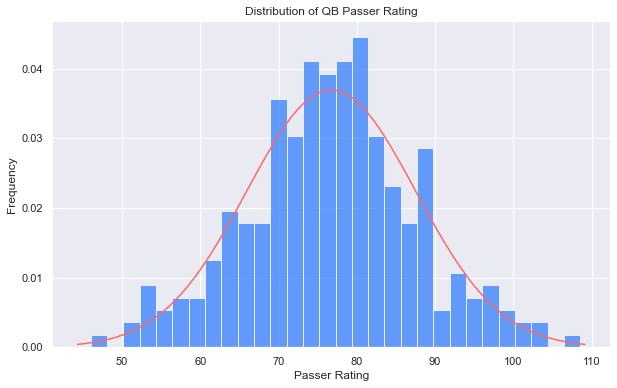

In [38]:
plot_hist_by_var(all_qb_stats, 'Rate')

We can plug in other performance statistics we capture to check those too, let's try pass attempts:

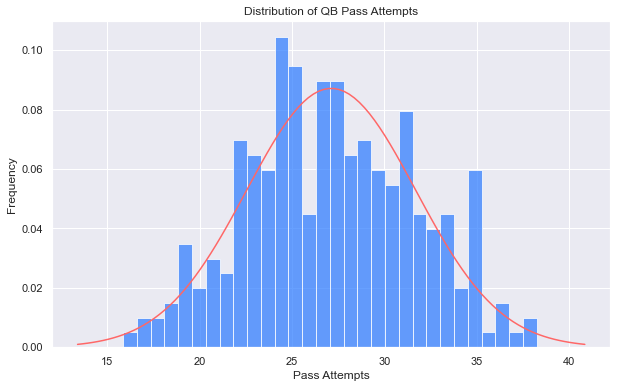

In [39]:
plot_hist_by_var(all_qb_stats, 'Att')

We can also check the distribution of our samples, the case and control QBs. We can do this using a Q-Q plot, which plots two sets of quantiles together so we can visually check if the dependent variable fits a normal distribution. This is important to verify so that we can make claims of statistically significant changes when performances deviate. 

In [40]:
def probplot_by_var(qb_stats, var):
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)
    stats.probplot(qb_stats[var], plot=plt)
    ax.get_lines()[0].set_markerfacecolor(blue)
    ax.get_lines()[1].set_color(red)
    plt.title('Probability Plot of {}'.format(stat_names[var]))
    plt.show()

Here are our case QBs passer ratings, prior to surgery, on a Q-Q plot. We can visually see that they fit the normal distribution well. 

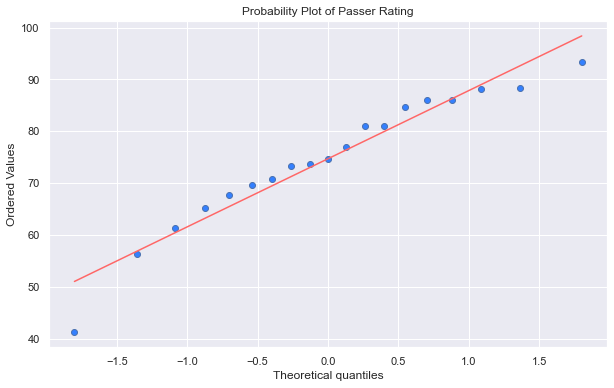

In [41]:
probplot_by_var(case_prev, 'Rate')

And the control QBs:

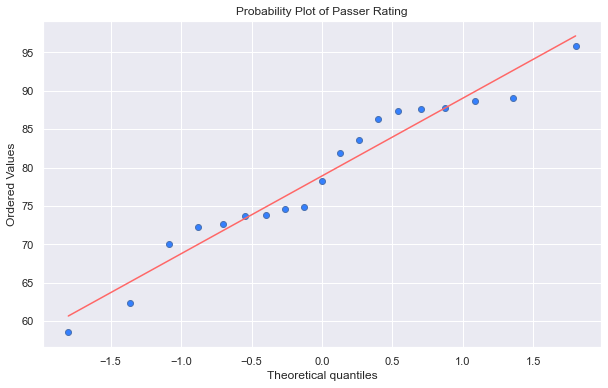

In [42]:
probplot_by_var(ctrl_prev, 'Rate')

We can check other statistics like passing yards:

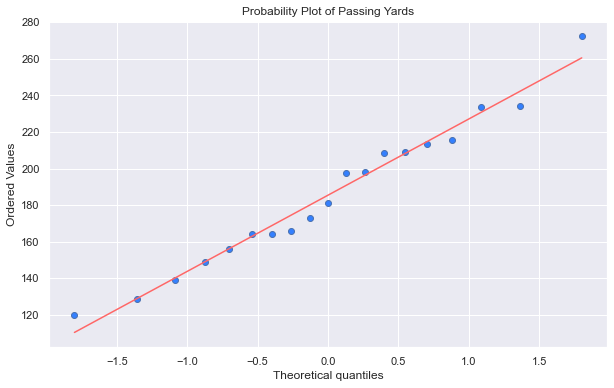

In [43]:
probplot_by_var(case_prev, 'Yds')

## QB Performance Statistics

Now lets take a closer look at the performance statistics of QBs. We are looking at passing statistics that are consistently recorded for all of our QBs going back to 1980, these are: Passer Rating (Rate), Completion Percentage (Cmp%), Passing Yards (Yds), Completions (Cmp), Attempts (Att), Yards per Pass Attempt (Y/A), Adjusted Yards per Pass Attempt (AY/A), Passing Touchdowns (TD), Interceptions (Int), Sacks (Sk), and Yards Lost to Sacks (Yds.1). 

<br>

Passer Rating and Adjusted Yards per Attempt are calculations of several aggregated statistics. 

Passer Rating is calculated as follows:

(a + b + c + d) / 6 * 100

where

a = (CMP/ATT - 0.3) * 5

b = (YDS/ATT - 3) * 0.25

c = (TD/ATT) * 20

d = 2.375 - (INT/ATT * 25)

<br>

Adjusted Yards per Pass Attempt is calculated as follows:

AY/A = (YDS + 20 * TD - 45 * INT) / ATT

We can find an easier way to look at a QB's statistics than numbers on a chart, with a radial plot. Since statistics have very different ranges though, such as passing yards in the hundreds and interceptions per game less than 5, we have to look at these as percentages. Let's calculate a QB's statistics as a percentage of the population average. 

In [44]:
def get_player_percent(player, df, all_qbs):
    res = df[df['Name']==player]
    res.set_index('Name', drop=True, inplace=True)
    res.drop(columns=['Age', 'Games'], inplace=True)
    res = res[['Rate', 'Cmp%', 'Yds', 'Cmp', 'Att', 'Y/A', 'AY/A', 'TD', 'Int', 'Sk', 'Yds.1']]
    for var in res.columns:
        avgvar = all_qbs[var].mean()
        res[var] = res[var]/avgvar
    return res

In [48]:
smith_prev = get_player_percent('Alex Smith', case_prev, all_qb_stats)
smith_post = get_player_percent('Alex Smith', case_post, all_qb_stats)
smith_prev

,Rate,Cmp%,Yds,Cmp,Att,Y/A,AY/A,TD,Int,Sk,Yds.1
Name,,,,,,,,,,,
Alex Smith,0.848928,0.970117,0.848582,0.922007,0.980547,0.882464,0.787074,0.603743,1.128319,1.263911,1.160729


Lets plot Alex Smith's statistics before and after his surgery, as a percentage of the average NFL QB statistics.

In [49]:
def radar_plot(df1, df2, df3=None, df4=None, prevpost=False, max_val=1.5):    
    label1 = df1.index[0]+' (Previous)' if prevpost else df1.index[0]
    label2 = df2.index[0]+' (Post)' if prevpost else df2.index[0]
    if df3 is not None and df4 is not None:
        plt.figure(figsize=(18,18))
        ax = plt.subplot(121, polar=True)
    else: 
        plt.figure(figsize=(14,8))
        ax = plt.subplot(111, polar=True)
        plt.title('{} vs {}: % of NFL Average'.format(label1, label2))

    categories=list(df1)
    N = len(categories)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    plt.xticks(angles[:-1], categories, color='black', size=12)
    ax.set_rlabel_position(0)
    yticks = [max_val*i/6 for i in range(1,6)]
    plt.yticks(yticks, [str(e) for e in yticks], color='grey', size=14)
    plt.ylim(0,max_val)
    colors = ['blue','red']
    
    values1 = df1.values.flatten().tolist()
    values1 += values1[:1]
    ax.plot(angles, values1, linewidth=1, linestyle='solid', color=colors[0], label=label1)
    ax.fill(angles, values1, color=colors[0], alpha=0.1)
    values2 = df2.values.flatten().tolist()
    values2 += values2[:1]
    ax.plot(angles, values2, linewidth=1, linestyle='solid', color=colors[1], label=label2)
    ax.fill(angles, values2, color=colors[1], alpha=0.1)
    plt.legend(loc=0, bbox_to_anchor=(0.1, 0.1), prop={'size': 13})
    
    if df3 is not None and df4 is not None:
        plt.title('{} vs {}: Previous, % of NFL Average'.format(label1, label2))
        ax = plt.subplot(122, polar=True)
        plt.xticks(angles[:-1], categories, color='black', size=12)
        ax.set_rlabel_position(0)
        yticks = [max_val*i/6 for i in range(1,6)]
        plt.yticks(yticks, [str(e) for e in yticks], color='grey', size=14)
        plt.ylim(0,max_val)
        values1 = df3.values.flatten().tolist()
        values1 += values1[:1]
        ax.plot(angles, values1, linewidth=1, linestyle='solid', color=colors[0], label=df3.index[0])
        ax.fill(angles, values1, color=colors[0], alpha=0.1)
        values2 = df4.values.flatten().tolist()
        values2 += values2[:1]
        ax.plot(angles, values2, linewidth=1, linestyle='solid', color=colors[1], label=df4.index[0])
        ax.fill(angles, values2, color=colors[1], alpha=0.1)
        plt.legend(loc=0, bbox_to_anchor=(0.1, 0.1), prop={'size': 13})
        plt.title('{} vs {}: Post, % of NFL Average'.format(df3.index[0], df4.index[0]))
    plt.show()

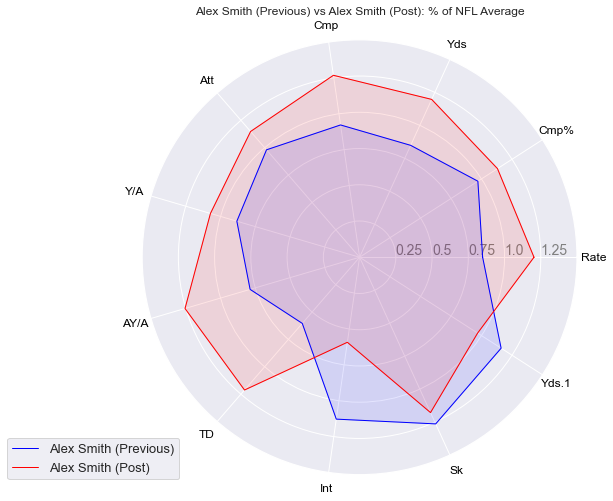

In [50]:
radar_plot(smith_prev, smith_post, prevpost=True)

Or we can compare two different QBs:

In [52]:
vick_prev = get_player_percent('Michael Vick', ctrl_prev, all_qb_stats)

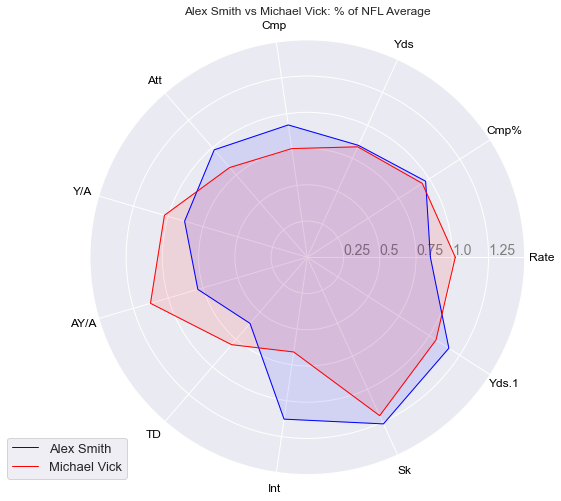

In [53]:
radar_plot(smith_prev, vick_prev)

And now lets look at Alex Smith and his control, Michael Vick, for their previous and post surgery/index performances.

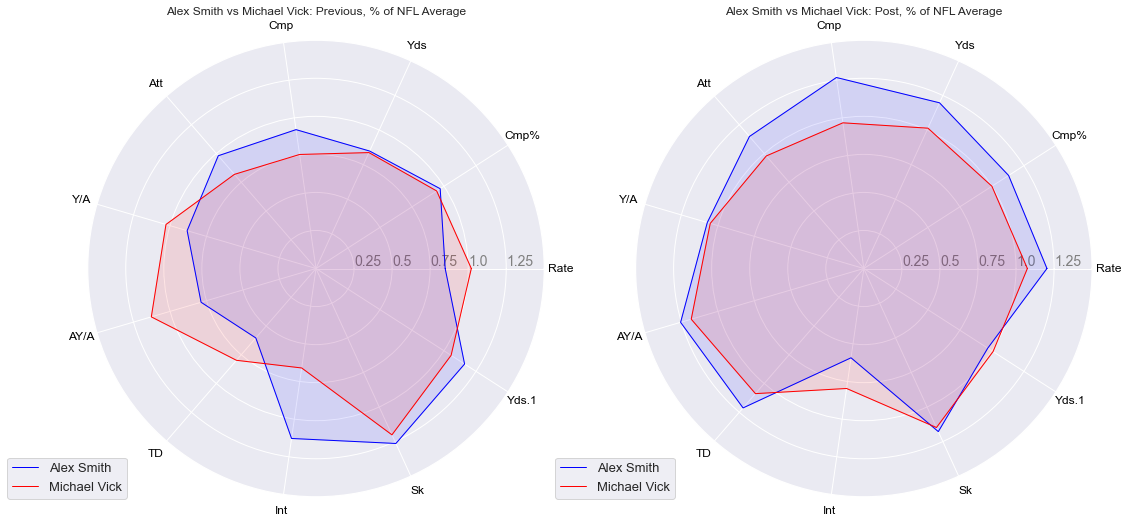

In [54]:
vick_post = get_player_percent('Michael Vick', ctrl_post, all_qb_stats)
radar_plot(smith_prev, vick_prev, smith_post, vick_post)

## Case QBs Pre and Post Surgery

The next step is to examine the performance statistics of our case QBs before and after their surgeries. We can look at the cohort as a whole. 

In [55]:
def plot_pre_post(case_prev, case_post, var):
    var_conv = {'Rate': 9, 'Games': 1, 'Cmp': 3, 'Att': 4, 'Cmp%': 5, 'Yds': 6, 'TD': 7, 'Int': 8, 'Sk': 10, 'Yds.1': 11, 'Y/A': 12, 'AY/A': 13}
    var_name = var
    var = var_conv[var]
    plt.figure(figsize=(10,6))
    plt.subplot(121)
    for i in range(len(case_prev)):
        plt.scatter(i/36, case_prev.iloc[i,var], color=blue, alpha=0.75)
        plt.scatter(1+i/36, case_post.iloc[i,var], color=red, alpha=0.75)
    plt.plot([0,0.5], [case_prev.iloc[:,var].mean(), case_prev.iloc[:,var].mean()], color=blue, linewidth=3)
    plt.plot([1,1.5], [case_post.iloc[:,var].mean(), case_post.iloc[:,var].mean()], color=red, linewidth=3)
    plt.xlim(-0.5,2)
    plt.xticks([.25,1.25], ['Previous', 'Post'])
    plt.ylabel(var_name)

    plt.subplot(122)
    for i in range(len(case_prev)):
        plt.scatter(1, case_prev.iloc[i,var], color=blue, alpha=0.75)
        plt.scatter(2, case_post.iloc[i,var], color=red, alpha=0.75)
        if case_post.iloc[i,var] - case_prev.iloc[i,var] > 0:
            c = 'green'
        else:
            c = 'red'
        plt.plot([1, 2], [case_prev.iloc[i,var], case_post.iloc[i,var]], color=c, linewidth=0.5, alpha=0.5)
    plt.xlim(0.5,2.5)
    plt.xticks([1,2], ['Previous', 'Post'])
    plt.suptitle('Case QB {} Previous and Post Surgery'.format(var_name))
    plt.show()

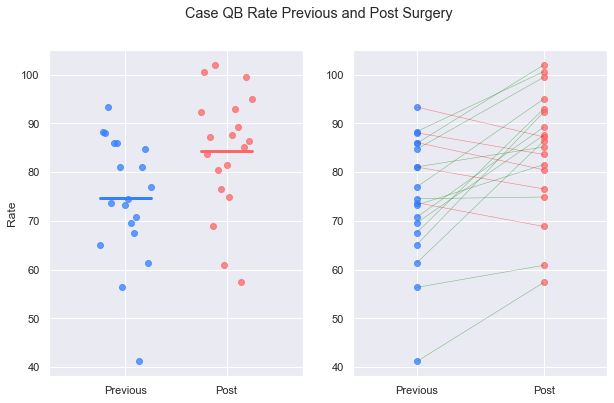

In [56]:
plot_pre_post(case_prev, case_post, 'Rate')